In [70]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

In [71]:
raw_data = pd.read_csv('../../data/external/diabetes.csv')

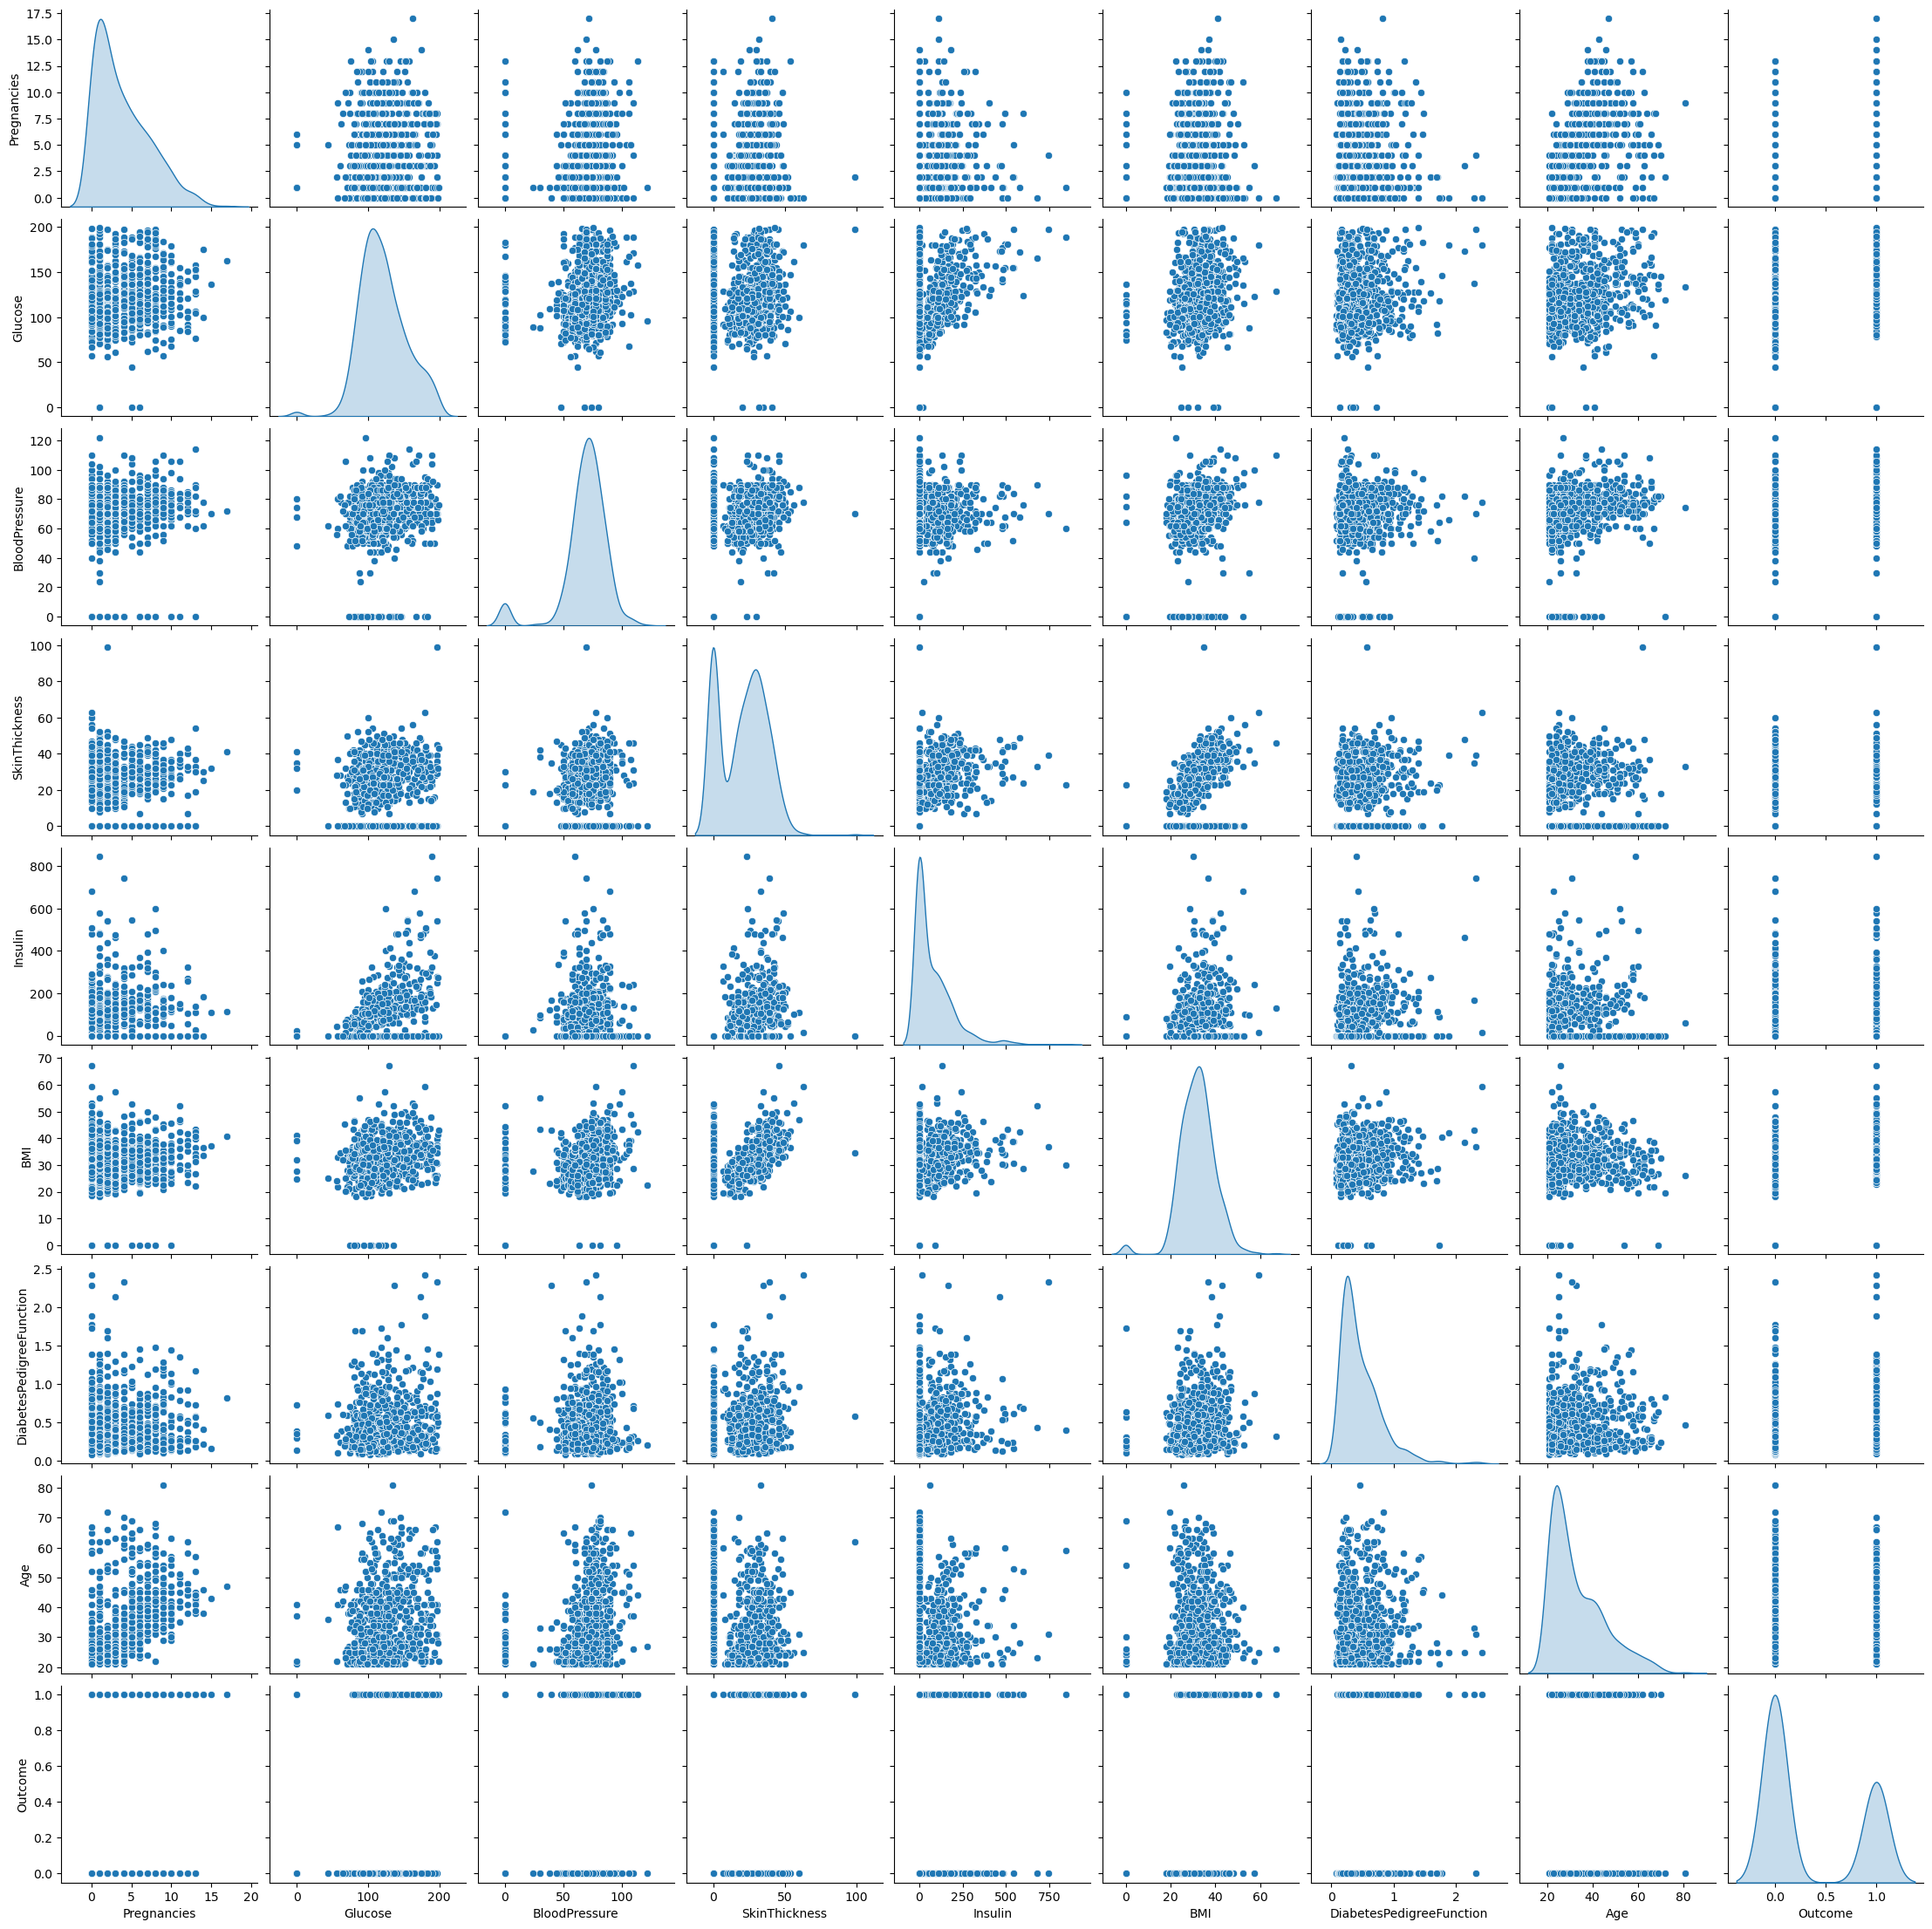

In [72]:
sns.pairplot(raw_data, kind='scatter', corner=False, diag_kind='kde')
plt.show()

In [73]:
from sklearn.model_selection import train_test_split

# Prepare features and target
X = raw_data.drop('Outcome', axis=1)
y = raw_data['Outcome']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [74]:
X_train

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
353,1,90,62,12,43,27.2,0.580,24
711,5,126,78,27,22,29.6,0.439,40
373,2,105,58,40,94,34.9,0.225,25
46,1,146,56,0,0,29.7,0.564,29
682,0,95,64,39,105,44.6,0.366,22
...,...,...,...,...,...,...,...,...
451,2,134,70,0,0,28.9,0.542,23
113,4,76,62,0,0,34.0,0.391,25
556,1,97,70,40,0,38.1,0.218,30
667,10,111,70,27,0,27.5,0.141,40


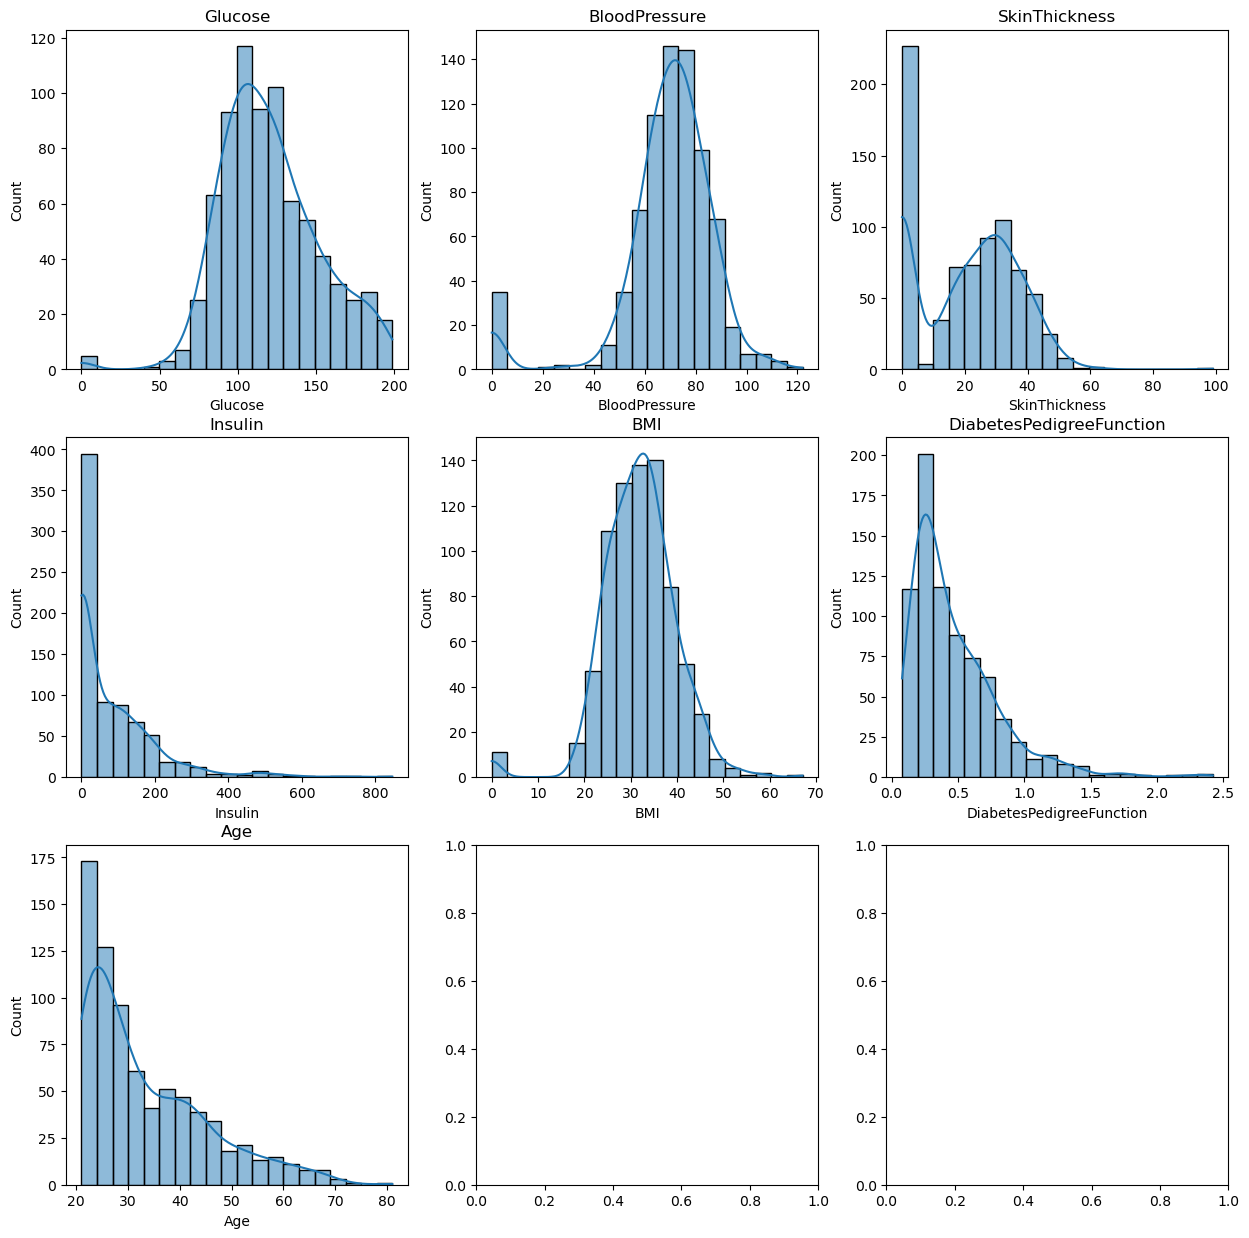

In [75]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

columns_to_impute = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

for i, column in enumerate(columns_to_impute):
    ax = axes[i // 3, i % 3]
    ax.set_title(f'{column}')
    sns.histplot(X[column], bins=20, kde=True, ax=ax)


In [76]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
# Define the preprocessing pipeline for columns where we want to impute the missing values.

def log_transform(x):
    return np.log(x + 1)  # Adding 1 to avoid log(0)

preprocessing_pipeline = Pipeline(steps=[
    ('imputer', ColumnTransformer(
        transformers=[
            ('mean_imputer', 
             SimpleImputer(missing_values=0, strategy='mean'), 
             ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']
            ),
            ('median_imputer', 
             SimpleImputer(missing_values=0, strategy='median'), 
             ['Insulin']
            ),
            ('log_transformer', 
             FunctionTransformer(func=np.log, inverse_func=np.exp, validate=False), 
             ['Age']
            )
        ],
        remainder='passthrough',
        force_int_remainder_cols=False
    )),
    ('scaler', StandardScaler())
])


In [80]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifierCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

classifiers = {
    'Ridge': RidgeClassifierCV(alphas=np.logspace(-3, 3, 15), scoring='accuracy', cv=5),
    'Logistic': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'NaiveBayes': GaussianNB()
}

param_grids = {
    'Ridge': {
        'classifier__alphas': [np.logspace(-4, 4, 20)]
    },
    'Logistic': {
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga'],
        'classifier__max_iter': [1000, 2000]
    },
    'RandomForest': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    },
    'GradientBoosting': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7]
    },
    'SVM': {
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__kernel': ['rbf', 'linear'],
        'classifier__gamma': ['scale', 'auto', 0.001, 0.01]
    },
    'KNN': {
        'classifier__n_neighbors': [3, 5, 7, 9, 11],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree']
    },
    'NaiveBayes': {}
}

In [78]:
selected_model = None

for name, classifier in classifiers.items():
    print(f'Classifier: {name}')
    pipeline = Pipeline(steps=[
        ('preprocessing', preprocessing_pipeline),
        ('classifier', classifier)
    ])
    
    # Fit the pipeline
    pipeline.fit(X_train, y_train)
    
    # Evaluate the classifier
    score = pipeline.score(X_test, y_test)
    print(f'Accuracy: {score:.2f}\n')

    if selected_model is None or score > selected_model[2]:
        selected_model = (name, pipeline, score)

Classifier: Ridge
Accuracy: 0.71

Classifier: Logistic
Accuracy: 0.71

Classifier: RandomForest
Accuracy: 0.74

Classifier: GradientBoosting
Accuracy: 0.74

Classifier: SVM
Accuracy: 0.73

Classifier: KNN
Accuracy: 0.73

Classifier: NaiveBayes
Accuracy: 0.70



In [79]:
eq = zip(selected_model[1].steps[-1][1].feature_importances_, X_train.columns)

for importance, feature in sorted(eq, key=lambda x: x[0], reverse=True):
    print(f'{feature}: {importance:.4f}')

Pregnancies: 0.2633
SkinThickness: 0.1551
BMI: 0.1309
Age: 0.1263
Insulin: 0.0877
Glucose: 0.0833
BloodPressure: 0.0790
DiabetesPedigreeFunction: 0.0742


### Similar exercise can also be done using atechnique called as grid search. In this case, we will use `GridSearchCV` to find the best hyperparameters for each classifier.

In [81]:
from sklearn.model_selection import GridSearchCV

# GridSearch for each classifier
grid_results = {}

for name, classifier in classifiers.items():
    if name in param_grids:  # Only run GridSearch for classifiers with defined grids
        print(f'Running GridSearch for {name}...')
        
        # Create pipeline
        pipeline = Pipeline([
            ('preprocessing', preprocessing_pipeline),
            ('classifier', classifier)
        ])
        
        # Create GridSearch
        grid_search = GridSearchCV(
            pipeline, 
            param_grids[name], 
            cv=5, 
            scoring='accuracy',
            n_jobs=-1,  # Use all available cores
            verbose=1   # Show progress
        )
        
        # Fit GridSearch
        grid_search.fit(X_train, y_train)
        
        # Store results
        grid_results[name] = {
            'best_score': grid_search.best_score_,
            'best_params': grid_search.best_params_,
            'best_estimator': grid_search.best_estimator_,
            'cv_results': grid_search.cv_results_
        }
        
        print(f'{name} - Best CV Score: {grid_search.best_score_:.4f}')
        print(f'{name} - Best Parameters: {grid_search.best_params_}')
        print('-' * 60)

Running GridSearch for Ridge...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Ridge - Best CV Score: 0.7802
Ridge - Best Parameters: {'classifier__alphas': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])}
------------------------------------------------------------
Running GridSearch for Logistic...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Logistic - Best CV Score: 0.7867
Logistic - Best Parameters: {'classifier__C': 1, 'classifier__max_iter': 1000, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
------------------------------------------------------------
Running GridSearch for RandomForest...
Fitting 5 folds for each of 108 candidates, t

In [87]:
pd.DataFrame(grid_results).T.sort_values(by='best_score', ascending=False)

,best_score,best_params,best_estimator,cv_results
Logistic,0.786685,"{'classifier__C': 1, 'classifier__max_iter': 1...",((ColumnTransformer(force_int_remainder_cols=F...,"{'mean_fit_time': [0.027131128311157226, 0.030..."
Ridge,0.780181,"{'classifier__alphas': [0.0001, 0.000263665089...",((ColumnTransformer(force_int_remainder_cols=F...,"{'mean_fit_time': [0.48873310089111327], 'std_..."
RandomForest,0.780155,"{'classifier__max_depth': None, 'classifier__m...",((ColumnTransformer(force_int_remainder_cols=F...,"{'mean_fit_time': [0.24384708404541017, 0.5317..."
SVM,0.776916,"{'classifier__C': 100, 'classifier__gamma': 0....",((ColumnTransformer(force_int_remainder_cols=F...,"{'mean_fit_time': [0.03162217140197754, 0.0324..."
GradientBoosting,0.763908,"{'classifier__learning_rate': 0.01, 'classifie...",((ColumnTransformer(force_int_remainder_cols=F...,"{'mean_fit_time': [0.22275691032409667, 0.4559..."
NaiveBayes,0.762228,{},((ColumnTransformer(force_int_remainder_cols=F...,"{'mean_fit_time': [0.01769909858703613], 'std_..."
KNN,0.757377,"{'classifier__algorithm': 'auto', 'classifier_...",((ColumnTransformer(force_int_remainder_cols=F...,"{'mean_fit_time': [0.017760419845581056, 0.022..."


You can see that with this new approach, we can easily get the best hyperparameters for each classifier. The `GridSearchCV` will automatically handle the cross-validation and hyperparameter tuning for us.
As per above, Logistic Regression has the best score, followed by Ridge Classifier. The other classifiers have lower scores.

## Randomized Search

The grid search approach is fine when you are exploring relatively few combinations, like in the previous example, but RandomizedSearchCV is often preferable, especially when the hyperparameter search space is large. This class can be used in much the same way as the GridSearchCV class, but instead of trying out all possible combinations it evaluates a fixed number of combinations, selecting a random value for each hyperparameter at every iteration. This may sound surprising, but this approach has several benefits:

1. If some of your hyperparameters are continuous (or discrete but with many possible values), and you let randomized search run for, say, 1,000 iterations, then it will explore 1,000 different values for each of these hyperparameters, whereas grid search would only explore the few values you listed for each one.

2. Suppose a hyperparameter does not actually make much difference, but you don’t know it yet. If it has 10 possible values and you add it to your grid search, then training will take 10 times longer. But if you add it to a random search, it will not make any difference.

3. If there are 6 hyperparameters to explore, each with 10 possible values, then grid search offers no other choice than training the model a million times, whereas random search can always run for any number of iterations you choose.